In [1]:
from __future__ import print_function, division
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

from itertools import chain
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from IPython.core.debugger import set_trace
import itertools
import seaborn as sns
from tqdm import tqdm
import random
import cv2

from natsort import natsorted
import collections
from IPython import display
import pylab as pl

from torch import nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF

from skorch import NeuralNetRegressor
from skorch.helper import predefined_split
from skorch import callbacks
from sklearn.model_selection import GridSearchCV
from collections import defaultdict         

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics.regression import median_absolute_error, mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import KFold
import c3d_wrapper
from data_utils import *
from models import *
from params import *

# Callbacks for skorch

In [2]:
from skorch.callbacks import Callback
from torchvision.utils import save_image

def to_tensor_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.permute(0,3,1,2)
    x = x.view(x.size(0), 1, 64, 64)
    return x

class Save_Reconstruction_Results(Callback):
    def __init__(self, path):
        self.path = path
        
    def on_epoch_end(self, net, **kwargs):
        for name in ['train', 'valid']:
            dataset = kwargs['dataset_'+name]
            rand_ix = np.random.randint(len(dataset))
            X,y = dataset[rand_ix]
            
            save_dir = os.path.join(self.path, name)
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            
            # target img
            y = y.numpy().transpose(1,2,3,0)  # (maxlen,h,w,3)
            
            # predicted img
            pred = net.predict(X[None,:])[0].transpose(1,2,3,0) # (maxlen,h,w,3)
            
            for sub_name,pic in zip(['target', 'pred'], [y,pred]):
                pic = to_tensor_img(torch.from_numpy(pic))
                save_image(pic, os.path.join(save_dir,sub_name+'.png'))

                
def fetch_samples_from_dataset(dataset):
    X = []
    Y = []
    for item in dataset:
        X.append(item[0].numpy())
        Y.append(item[1].numpy())
        
    return np.array(X), np.array(Y)

def record_score(y_pred, y_true, epoch, phase, log_path="score_log.txt"):
    deco = f"=== EPOCH-{epoch} / {phase} === summary"
    mae = f"MAE : {mean_absolute_error(y_true, y_pred)}"
    mse = f"MSE : {mean_squared_error(y_true, y_pred)}"
    rmse = f"RMSE : {np.sqrt(mean_squared_error(y_true, y_pred))}"
    r2 = f"R^2 : {r2_score(y_true, y_pred, multioutput='variance_weighted')}"
    ev = f"Explained variation : {explained_variance_score(y_true, y_pred, multioutput='variance_weighted')}"
    
    msg = '\n'.join([deco, mae, mse, rmse, r2, ev])
    os.system("echo \'{}\' >> {}".format(msg, log_path))
    

class Report_Regression_Results(Callback):
    def __init__(self, columns, scaler=None, period=5, log_path="score_log.txt"):
        self.columns = columns
        self.scaler = scaler
        self.period = period
        
        self.loss_history = defaultdict(list)
        if os.path.exists(log_path):
            os.system(f"rm {log_path}")
            
        self.log_path = log_path
    
    def on_epoch_end(self, net, **kwargs):
        if len(net.history) % self.period == 0:
            for phase in ['train', 'valid']:
                self.loss_history[phase].append(net.history[-1, f'{phase}_loss'])
            
            for phase in ['train', 'valid']:
                dataset = kwargs['dataset_'+phase]

                X, y_true = fetch_samples_from_dataset(dataset)
                y_pred = net.predict(X)
                if self.scaler:
                    y_pred = self.scaler.inverse_transform(y_pred)
                    y_true = self.scaler.inverse_transform(y_true)
                
                record_score(y_pred, y_true, epoch=len(net.history), phase=phase, log_path=self.log_path)

                report_lerning_process(columns=self.columns,
                                       epoch=len(net.history),
                                       phase=phase,
                                       y_pred=y_pred,
                                       y_true=y_true,
                                       loss_history=self.loss_history)
        
    


# Custom criterion

In [3]:
def Normal(x, mu=0.0, sigma=1.0):
    if type(x)==torch.Tensor:
        x = x.detach().cpu().numpy()
        
    res = (1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2) )).astype(np.float32)
    return torch.tensor(res).float().cuda()

In [4]:
from torch.nn.modules.loss import _Loss

class MyCriterion(_Loss):
    def __init__(self, mu, sigma):
        super(MyCriterion, self).__init__()
        self.mu = mu
        self.sigma = sigma
        
    def forward(self, x, y):
        return nn.MSELoss()(x,y) + torch.mean((1-x.std(0))**2)
    
#         set_trace()
        
#         valid_mask = ~(y.view(y.size(0),FRAME_MAXLEN,-1)==0).all(dim=2)
#         valid_mask = valid_mask.float()
#         return torch.mean(torch.sum((valid_mask * ((x-y)**2).mean((1,3,4))),1)/torch.sum(valid_mask,1))

# Training Loop

In [5]:
from dask.distributed import Client
client = Client()
from sklearn.externals import joblib

/home/hossay/anaconda3/envs/torch/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [6]:
def cross_validation_loop(model,
                          super_class=NeuralNetRegressor,
                          task = 'regression@pretrained',
                          n_splits=5,
                          feature_extraction_model=None, feature_layer='conv1',
                          # dataset path
                          input_file = "../../preprocess/data/person_detection_and_tracking_results_drop.pkl",
                          target_file = "../../preprocess/data/targets_dataframe.pkl",
                          callback_list=['early_stop', 'prog_bar', 'report_regression_results'],
                          scores=['MAPE', 'MAE', 'RMSE', 'R2', 'Explained variation']):
    

    data_dict = prepare_dataset(input_file, target_file,
                                feature_extraction_model=feature_extraction_model, layer=feature_layer)

    # holdouf test set for final evaluation
    test_dataset = dataset_init(task, 
                                data_dict['test_X'], data_dict['test_y'],
                                scaler=data_dict['scaler'], name='test')
    
    # can be modified !
    scores = { k:[] for k in scores }
    
    data_locations = np.array(data_dict['train_vids'])

    input_df = data_dict['input_df']
    target_df = data_dict['target_df']
    scaler = data_dict['scaler']
    
    if callback_list:
        call_backs_map = {'early_stop': callbacks.EarlyStopping(),
                          'prog_bar': callbacks.ProgressBar(),
                          'lr_scheduler': callbacks.LRScheduler(policy='WarmRestartLR'),
                          'report_regression_results': Report_Regression_Results(columns=target_columns, period=1, scaler=scaler),
                          'save_reconstruction_results': Save_Reconstruction_Results(path='./results')
                         }

        callback_list = [ call_backs_map.get(cb) for cb in callback_list ]
    
    # K-fold CV
    kf = KFold(n_splits=n_splits)
    
    for train, valid in kf.split(data_locations):
        
        # split trainset with train/valid
        train_split, valid_split = data_locations[train], data_locations[valid]

        train_X, train_y = filter_input_df_with_vids(input_df,train_split), filter_target_df_with_vids(target_df,train_split)
        valid_X, valid_y = filter_input_df_with_vids(input_df,valid_split), filter_target_df_with_vids(target_df,valid_split)

        # dsataset !!
        train_dataset = dataset_init(task, train_X, train_y, scaler=scaler, name='train')
        valid_dataset = dataset_init(task, valid_X, valid_y, scaler=scaler, name='valid')
        
        # init net
        net = super_class(
            model,
            batch_size=8,
            max_epochs=5,
            lr = 1e-4,
            optimizer=torch.optim.SGD,
            optimizer__weight_decay=1e-6,
            device='cuda',
            #criterion=MyCriterion,
            #criterion__mu=train_y.values.mean(0),
            #criterion__sigma=train_y.values.std(0),
            train_split=predefined_split(valid_dataset),
            # Shuffle training data on each epoch
            iterator_train__shuffle=True,
            warm_start=False, # re-init the module
            callbacks=callback_list,
        )
        
        with joblib.parallel_backend('dask', scheduler_host='127.0.0.1:8786'):
            # implicit train/validate loop for each CV split
            net.fit(train_dataset, y=None)
                    
        return net, train_dataset, valid_dataset, scaler

In [7]:
# pretrained c3d net( tensorflow )
tf_model = TF_Model()

visualize_conv_featsmap('7157030_test_0_trial_1', tf_model, layer='conv1')

initialize with pretrained weight file...
Done!


In [8]:
task = 'regression@pretrained'
# task = 'reconstruction@pretrained'
# task = 'reconstruction@fromscratch'

super_class = NeuralNetRegressor
if task.split('@')[1]=='fromscratch':
    super_class = AutoEncoderNet

net, train_dataset, valid_dataset, scaler = cross_validation_loop(super_class=super_class,
                      #feature_extraction_model=tf_model, feature_layer='conv5',
                      model=eval('_'.join(task.split('@')).capitalize()),
                      task=task,
                      callback_list=['early_stop', 'prog_bar', 'report_regression_results'])

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.8667        0.8641  21.5784


      2        0.6166        0.7734  20.3029


      3        0.4293        0.8174  20.1633


      4        0.3084        1.5848  20.2688


      5        0.2008        0.7996  20.3072


In [9]:
X, y_true = fetch_samples_from_dataset(valid_dataset)
y_pred = net.predict(X)

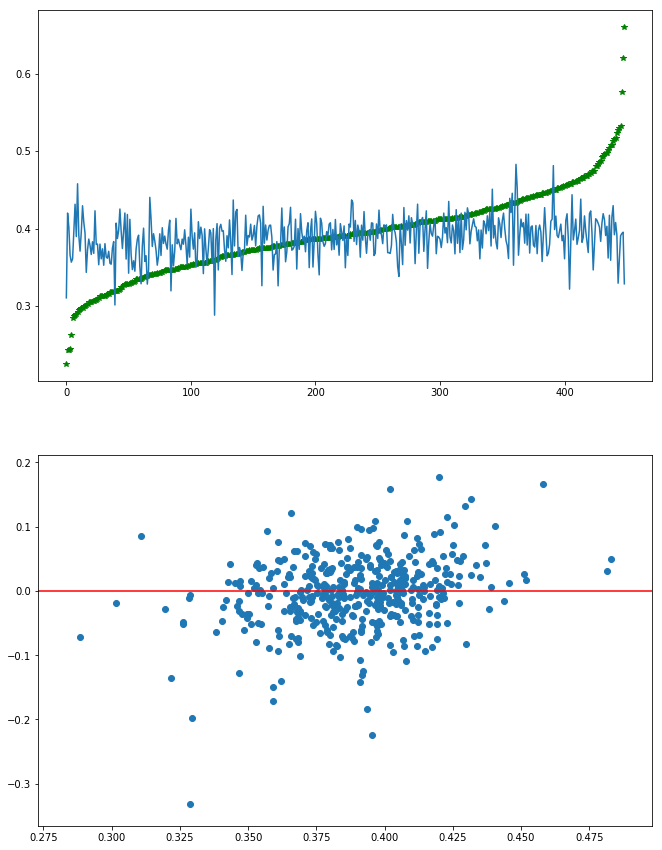

In [10]:
sampled_y_true = scaler.inverse_transform(y_true)[:,-1]
sampled_y_pred = scaler.inverse_transform(y_pred)[:,-1]

sorted_ixs = np.argsort(sampled_y_true)

sampled_y_true = sampled_y_true[sorted_ixs]
sampled_y_pred = sampled_y_pred[sorted_ixs]

fig, axes = plt.subplots(2, figsize=(11,15))
axes[0].plot(sampled_y_true, 'g*')
axes[0].plot(sampled_y_pred)
axes[1].scatter(sampled_y_pred, sampled_y_pred-sampled_y_true)
axes[1].axhline(y=0.0, color='r', linestyle='-')

In [11]:
r2_score(y_true, y_pred, multioutput='raw_values')

array([-0.03969615])

In [12]:
mean_absolute_error(y_true, y_pred, multioutput='raw_values')

array([0.6564241], dtype=float32)